In [49]:
#Import libraries#

import cv2
import scipy.misc as sm
import numpy as np
from matplotlib import pyplot as plt


In [50]:
#Ref_image#
#
test_image = "ficarra.jpg"


In [51]:
#Dataset#
#
data_set = ["ficarra.jpg","ficarra.jpg","marcelo.jpg","obama1.jpg","gianni-morandi.jpg","template.jpg"]


In [52]:
#Reading each image from dataset#
#

listim = []
test_image = cv2.imread("ficarra.jpg") #Setting Ref_image#

for i in range (0,len(data_set)):
    img2 = cv2.imread(data_set[i])
    #img2 = cv2.resize(img2, (358,267))
    listim.append(img2) #Update the list with reading image#
    

In [53]:
#Lista[n] shape#

listim[0].shape


(358, 267, 3)

In [54]:
#Test_image shape#

test_image.shape


(358, 267, 3)

In [55]:

#Set resize for ref_image 
#test_image  = cv2.resize(test_image, (100, 50))


In [56]:
test_image.shape

(358, 267, 3)

In [57]:

data_setGRAY = [] #Vector for gray images from dataset#
dataset_size = [] #Vector for size from dataset#

test_imageGRAY = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY) #Setting gray scale for Ref_image#

for j in range (0,len(listim)):
    
    data_set = cv2.cvtColor(listim[j], cv2.COLOR_BGR2GRAY)
    data_setGRAY.append(data_set) #Update gray scale dataset#
    size= listim[j].shape
    dataset_size.append(size) #Update dataset size vector#
    

In [58]:
#for k in range (0,len(data_setGRAY)):
    #plt.imshow (data_setGRAY[k], cmap = "gray")

In [59]:

def init_feature(name):

    detector = None
    norm = None
    matcher = None

    FLANN_INDEX_KDTREE = 1  # Bug: flann enums are missing
    FLANN_INDEX_LSH = 6
    chunks = name.split('-') #Inizialize chuncks like an object splitted by a space#
    if chunks[0] == 'sift':
        detector = cv2.xfeatures2d.SIFT_create()
        norm = cv2.NORM_L2
    elif chunks[0] == 'surf':
        detector = cv2.xfeatures2d.SURF_create(800)
        norm = cv2.NORM_L2
    elif chunks[0] == 'orb':
        detector = cv2.ORB_create(400)
        norm = cv2.NORM_HAMMING
    elif chunks[0] == 'akaze':
        detector = cv2.AKAZE_create()
        norm = cv2.NORM_HAMMING
    elif chunks[0] == 'brisk':
        detector = cv2.BRISK_create()
        norm = cv2.NORM_HAMMING
    else:
        return None, None


    if 'flann' in chunks:
        if norm == cv2.NORM_L2:
            flann_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        else:
            flann_params = dict(algorithm=FLANN_INDEX_LSH,
                                table_number=6,  #12#6
                                key_size=12,  #20#12
                                multi_probe_level=1)  #2#1
        matcher = cv2.FlannBasedMatcher(flann_params, {})  # Bug : need to pass empty dict (#1329)#
    else:
        matcher = cv2.BFMatcher(norm)
    return detector, matcher


In [60]:

#detector_matcher = 'sift-flann'#
detector_matcher = 'orb-flann' 
#detector_matcher = 'orb-flann'#
#detector_matcher = 'akaze-flann'#
#detector_matcher = 'brisk-flann'#


In [61]:

detector,matcher = init_feature(detector_matcher) #Inizialize detector and matcher#


In [62]:

#Set kp1,desc1,img1_annotated for Ref_image#
kp1, desc1 = detector.detectAndCompute(test_imageGRAY, None)
img1_annotated = np.zeros_like(test_imageGRAY)
img1_annotated = cv2.drawKeypoints(test_imageGRAY,kp1,img1_annotated,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#Set empty arrays for iterable img2#
img2_annotatedZEROS= []
img2_annotatedARRAY= []
raw_matchesARRAY= []

for z in range (0,len(data_setGRAY)):
    
    img2= data_setGRAY[z]
    kp2, desc2  = detector.detectAndCompute(data_setGRAY[z], None)
    img2_annotated = np.zeros_like(data_setGRAY[z])
    img2_annotatedDRAW = cv2.drawKeypoints(img2,kp2,img2_annotated,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_annotatedZEROS.append(img2_annotated)
    img2_annotatedARRAY.append(img2_annotatedDRAW)
    raw_matches = matcher.knnMatch(desc1, trainDescriptors=desc2, k=2)
    raw_matchesARRAY.append(raw_matches)
    

In [63]:

#Output number of rawmatches for each array cell#
for f in range (0,len(raw_matchesARRAY)):
    print np.size(raw_matchesARRAY[f])
    

796
796
796
398
796
398


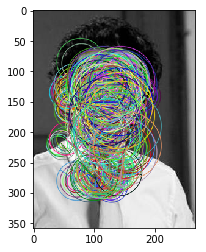

In [64]:

#plt.imshow(img2_annotatedARRAY[n])#
plt.imshow(img2_annotatedARRAY[0])


In [65]:

#Set manually the params for each img2#
kp2, desc2 = detector.detectAndCompute(data_setGRAY[0], None)


In [66]:

def filter_matches(kp1, kp2, matches, ratio=0.75):

    mkp1, mkp2 = [], []


    m = []

    for m in matches:

        if len(m) == 2 and m[0].distance < m[1].distance * ratio:

            m = m[0]
            mkp1.append(kp1[m.queryIdx])
            mkp2.append(kp2[m.trainIdx])


    #if debug_mode:print("appended keypoints")
    p1 = np.float32([kp.pt for kp in mkp1])
    p2 = np.float32([kp.pt for kp in mkp2])
    kp_pairs = zip(mkp1, mkp2)
    return p1, p2, kp_pairs


In [67]:

#Set the params for filter_matches function#
q, a, kp_pairs = filter_matches(kp1, kp2, raw_matchesARRAY[0])


In [68]:

#Inizialize variables for cv2.findHomography function#
H, status = cv2.findHomography(q,a,cv2.RANSAC,5.0)


In [69]:

h1, w1 = test_imageGRAY.shape[:2]
h2, w2 = data_setGRAY[0].shape[:2]
vis = np.zeros((max(h1, h2), w1 + w2), np.uint8)
    

In [70]:

vis[:h1, :w1] = test_imageGRAY


In [71]:

vis[:h2, w1:w1+ w2] = data_setGRAY[0]
    

In [72]:

np.shape(kp_pairs)


(398, 2)

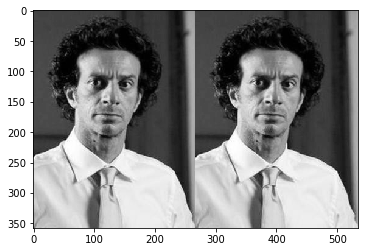

In [73]:

#Output vis variable#
plt.imshow(vis, cmap= "gray")


In [74]:

#Setting gray scale for vis variable#
vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)


In [75]:

green = (0, 255, 0)
red = (0, 0, 255)


In [76]:

p1 = np.int32([kpp[0].pt for kpp in kp_pairs])
p2 = np.int32([kpp[1].pt for kpp in kp_pairs]) + (w1, 0)


In [77]:

corners_starting = np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]])
corners_ending = np.int32(cv2.perspectiveTransform(corners_starting.reshape(1, -1, 2), H).reshape(-1, 2) + (w1, 0))
vis = cv2.polylines(vis, [corners_ending], True, (255, 0, 0),6)


In [78]:

for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
    if inlier:
        cv2.line(vis, (x1, y1), (x2, y2), green)
        

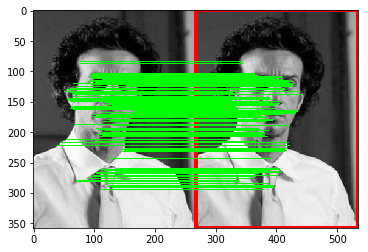

In [79]:

plt.imshow(vis)
